<h1>Reinforcement Learning Final Project - Stock Trading Algorithm</h1>
    
<br>
Implementation using the 
"anytrading" environment in OpenAIGym
<br>
https://github.com/AminHP/gym-anytrading

In [2]:
pip install gym-anytrading

Note: you may need to restart the kernel to use updated packages.


In [3]:
# importing the OpenAIGym Environment for stock trading
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from gym_anytrading.datasets import STOCKS_GOOGL
import random


In [4]:
env = gym.make('stocks-v0')
custom_env = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 1,
               frame_bound = (1, 500))

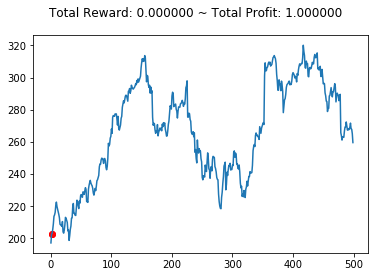

In [5]:
custom_env.reset()
custom_env.render()

In [6]:
# Google Stock dataset
custom_env.df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000


Max_possible_profit signifies that if the market didn't have trade fees, you could have earned 16.163897982248805 units of currency by starting with 1.0. In other words, your money increased over 1600%.

In [7]:
custom_env.max_possible_profit()

16.163897982248805

In [8]:
print(custom_env.action_space)
# 0 for sell and 1 for buying

Discrete(2)


In [9]:
action = 1
print(custom_env.step(action))

(array([[202.382385,   5.43544 ]]), 0, False, {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1})


In [10]:
observation, reward, done, info = custom_env.step(action)

<h2>Random and Heuristic Methods:</h2>

**Method 1: Random Buy/Sell**

[[196.946945   0.      ]]
info:  {'total_reward': 72.26234699999972, 'total_profit': 0.2323031497382657, 'position': 0}


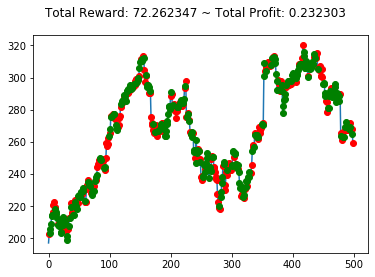

In [11]:
env_1 = gym.make('stocks-v0', df = STOCKS_GOOGL, window_size = 1, frame_bound = (1, 500))

state = env_1.reset()
print(state)
while True:
    action = env_1.action_space.sample()
    state, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()

**Method 2: Buy low sell high (last ten days moving average)**

info:  {'total_reward': 6.946976000000234, 'total_profit': 0.6305466232412168, 'position': 1}


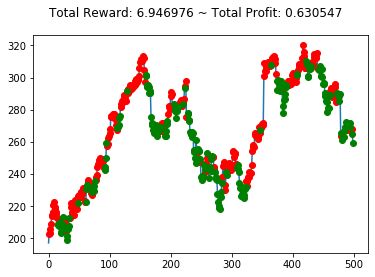

In [12]:
observation = env_1.reset()

last_ten_days = [] # moving average
moving_avg = 0
while True:
    if len(last_ten_days) < 10:
        last_ten_days.append(observation[0][0])
    else:
        last_ten_days.pop(0)
        last_ten_days.append(observation[0][0])
    moving_avg = sum(last_ten_days) / len(last_ten_days)
    
    
    if observation[0][0] < moving_avg:
        action = 1 # buy)
    elif observation[0][0] > moving_avg:
        action = 0 # sell
    
    observation, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()
    

**Method 3: Buy and Hold Strategy**
<br>
Buy the stock at the beginning and hold throughout the period and sell stock at the very end.

info:  {'total_reward': 64.80979999999997, 'total_profit': 1.299563520310515, 'position': 0}


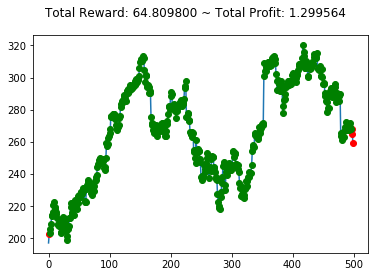

In [13]:
state = env_1.reset()
count = 0
while True:
    count += 1
    action = 1
    if count > 495:
        action = 0
    state, reward, done, info = env_1.step(action)
    
    if done:
        print("info: ", info)
        break

env_1.render_all()

<h2>Reinforcement Learning Methods:</h2>

**Method 4: Deep Q-Learning (DQN)**

In [14]:
# Parameters
gamma = 0.99
actsize = env_1.action_space.n
obssize = env_1.observation_space.low.size

In [15]:
def model_creator():
    model = keras.Sequential()
    model.add(layers.Dense(32,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(actsize,activation="linear"))
    return model

In [16]:
batch_size = 10
# Model used for selecting actions (principal)
model = model_creator()
# Then create the target model. This will periodically be copied from the principal network 
model_target = model_creator()

model.build((batch_size,obssize,))
model_target.build((batch_size,obssize,))

In [17]:
# environment
env_1 = gym.make('stocks-v0', df = STOCKS_GOOGL, window_size = 1, frame_bound = (1, 500))

running reward: 0.00 at episode 1, profit {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}, epsilon 0.9900498337491681
running reward: 0.00 at episode 2, profit {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}, epsilon 0.9801986733067553
running reward: 0.00 at episode 3, profit {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}, epsilon 0.9704455335485082
running reward: 0.00 at episode 4, profit {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}, epsilon 0.9607894391523232
running reward: 0.00 at episode 5, profit {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}, epsilon 0.951229424500714
running reward: 13.06 at episode 6, profit {'total_reward': 13.058059999999983, 'total_profit': 1.0484190648486174, 'position': 0}, epsilon 0.9417645335842487
running reward: 0.00 at episode 7, profit {'total_reward': 13.058059999999983, 'total_profit': 1.0484190648486174, 'position': 0}, epsilon 0.9323938199059483
running reward: 0.00 at episode 8, profit {'

running reward: -0.19 at episode 72, profit {'total_reward': 11.731736999999924, 'total_profit': 0.8154342067903271, 'position': 0}, epsilon 0.4867522559599717
running reward: 0.00 at episode 73, profit {'total_reward': 11.731736999999924, 'total_profit': 0.8154342067903271, 'position': 1}, epsilon 0.48190899009020244
running reward: 0.00 at episode 74, profit {'total_reward': 11.731736999999924, 'total_profit': 0.8154342067903271, 'position': 1}, epsilon 0.4771139155210344
running reward: 0.00 at episode 75, profit {'total_reward': 11.731736999999924, 'total_profit': 0.8154342067903271, 'position': 1}, epsilon 0.4723665527410147
running reward: 0.00 at episode 76, profit {'total_reward': 11.731736999999924, 'total_profit': 0.8154342067903271, 'position': 1}, epsilon 0.46766642700990924
running reward: 8.26 at episode 77, profit {'total_reward': 19.989991999999944, 'total_profit': 0.8321421443799657, 'position': 0}, epsilon 0.46301306831122807
running reward: 0.00 at episode 78, profit

running reward: 0.00 at episode 131, profit {'total_reward': 40.865876999999955, 'total_profit': 0.775285787394578, 'position': 0}, epsilon 0.2698200563846868
running reward: 0.00 at episode 132, profit {'total_reward': 40.865876999999955, 'total_profit': 0.775285787394578, 'position': 0}, epsilon 0.26713530196585034
running reward: 0.00 at episode 133, profit {'total_reward': 40.865876999999955, 'total_profit': 0.775285787394578, 'position': 0}, epsilon 0.26447726129982396
running reward: 0.00 at episode 134, profit {'total_reward': 40.865876999999955, 'total_profit': 0.775285787394578, 'position': 0}, epsilon 0.261845668580326
running reward: 0.00 at episode 135, profit {'total_reward': 40.865876999999955, 'total_profit': 0.775285787394578, 'position': 0}, epsilon 0.2592402606458915
running reward: 0.00 at episode 136, profit {'total_reward': 40.865876999999955, 'total_profit': 0.775285787394578, 'position': 0}, epsilon 0.2566607769535559
running reward: 0.00 at episode 137, profit {

running reward: 0.00 at episode 188, profit {'total_reward': 39.36438199999998, 'total_profit': 0.704125385406297, 'position': 1}, epsilon 0.15259010575688386
running reward: -5.88 at episode 189, profit {'total_reward': 33.4834919999999, 'total_profit': 0.6785959550364311, 'position': 0}, epsilon 0.15107180883637084
running reward: 0.00 at episode 190, profit {'total_reward': 33.4834919999999, 'total_profit': 0.6785959550364311, 'position': 0}, epsilon 0.14956861922263504
running reward: 0.00 at episode 191, profit {'total_reward': 33.4834919999999, 'total_profit': 0.6785959550364311, 'position': 0}, epsilon 0.14808038659546244
running reward: 0.00 at episode 192, profit {'total_reward': 33.4834919999999, 'total_profit': 0.6785959550364311, 'position': 1}, epsilon 0.14660696213035015
running reward: 4.19 at episode 193, profit {'total_reward': 37.672700999999904, 'total_profit': 0.6789541669943993, 'position': 0}, epsilon 0.14514819848362373
running reward: 0.00 at episode 194, profit

running reward: 0.00 at episode 248, profit {'total_reward': 24.33935699999995, 'total_profit': 0.6087984045413702, 'position': 0}, epsilon 0.08374322559219596
running reward: 0.00 at episode 249, profit {'total_reward': 24.33935699999995, 'total_profit': 0.6087984045413702, 'position': 0}, epsilon 0.08290996657517266
running reward: 0.00 at episode 250, profit {'total_reward': 24.33935699999995, 'total_profit': 0.6087984045413702, 'position': 0}, epsilon 0.0820849986238988
running reward: 0.00 at episode 251, profit {'total_reward': 24.33935699999995, 'total_profit': 0.6087984045413702, 'position': 0}, epsilon 0.08126823924089167
running reward: 0.00 at episode 252, profit {'total_reward': 24.33935699999995, 'total_profit': 0.6087984045413702, 'position': 0}, epsilon 0.08045960674953244
running reward: 0.00 at episode 253, profit {'total_reward': 24.33935699999995, 'total_profit': 0.6087984045413702, 'position': 0}, epsilon 0.07965902028589801
running reward: 0.00 at episode 254, prof

running reward: 0.00 at episode 308, profit {'total_reward': 41.52153100000004, 'total_profit': 0.5889191537751386, 'position': 0}, epsilon 0.045959256649044204
running reward: 0.00 at episode 309, profit {'total_reward': 41.52153100000004, 'total_profit': 0.5889191537751386, 'position': 0}, epsilon 0.04550195440462157
running reward: 0.00 at episode 310, profit {'total_reward': 41.52153100000004, 'total_profit': 0.5889191537751386, 'position': 0}, epsilon 0.0450492023935578
running reward: 0.00 at episode 311, profit {'total_reward': 41.52153100000004, 'total_profit': 0.5889191537751386, 'position': 0}, epsilon 0.044600955340274535
running reward: 0.00 at episode 312, profit {'total_reward': 41.52153100000004, 'total_profit': 0.5889191537751386, 'position': 0}, epsilon 0.04415716841969286
running reward: 0.00 at episode 313, profit {'total_reward': 41.52153100000004, 'total_profit': 0.5889191537751386, 'position': 0}, epsilon 0.04371779725275094
running reward: 0.00 at episode 314, pr

running reward: 0.00 at episode 368, profit {'total_reward': 94.88488900000007, 'total_profit': 0.6815125346037779, 'position': 0}, epsilon 0.025222974835227212
running reward: 0.00 at episode 369, profit {'total_reward': 94.88488900000007, 'total_profit': 0.6815125346037779, 'position': 0}, epsilon 0.024972002042276155
running reward: 0.00 at episode 370, profit {'total_reward': 94.88488900000007, 'total_profit': 0.6815125346037779, 'position': 0}, epsilon 0.024723526470339388
running reward: 0.00 at episode 371, profit {'total_reward': 94.88488900000007, 'total_profit': 0.6815125346037779, 'position': 0}, epsilon 0.02447752327165267
running reward: 0.00 at episode 372, profit {'total_reward': 94.88488900000007, 'total_profit': 0.6815125346037779, 'position': 0}, epsilon 0.024233967845691113
running reward: 0.00 at episode 373, profit {'total_reward': 94.88488900000007, 'total_profit': 0.6815125346037779, 'position': 0}, epsilon 0.023992835836709175
running reward: 0.00 at episode 374

running reward: 4.58 at episode 428, profit {'total_reward': 97.13711700000002, 'total_profit': 0.6467464524928485, 'position': 0}, epsilon 0.013842662086479501
running reward: 0.00 at episode 429, profit {'total_reward': 97.13711700000002, 'total_profit': 0.6467464524928485, 'position': 1}, epsilon 0.013704925297364945
running reward: 0.00 at episode 430, profit {'total_reward': 97.13711700000002, 'total_profit': 0.6467464524928485, 'position': 1}, epsilon 0.013568559012200934
running reward: 0.00 at episode 431, profit {'total_reward': 97.13711700000002, 'total_profit': 0.6467464524928485, 'position': 1}, epsilon 0.013433549594245302
running reward: 0.00 at episode 432, profit {'total_reward': 97.13711700000002, 'total_profit': 0.6467464524928485, 'position': 1}, epsilon 0.013299883542443767
running reward: 0.00 at episode 433, profit {'total_reward': 97.13711700000002, 'total_profit': 0.6467464524928485, 'position': 1}, epsilon 0.013167547490079751
running reward: 0.00 at episode 43

running reward: 0.00 at episode 488, profit {'total_reward': 82.71267800000007, 'total_profit': 0.6070265371648443, 'position': 0}, epsilon 0.007597014027577567
running reward: 0.00 at episode 489, profit {'total_reward': 82.71267800000007, 'total_profit': 0.6070265371648443, 'position': 0}, epsilon 0.00752142247499327
running reward: 0.00 at episode 490, profit {'total_reward': 82.71267800000007, 'total_profit': 0.6070265371648443, 'position': 0}, epsilon 0.007446583070924338
running reward: 0.00 at episode 491, profit {'total_reward': 82.71267800000007, 'total_profit': 0.6070265371648443, 'position': 0}, epsilon 0.007372488331368012
running reward: 0.00 at episode 492, profit {'total_reward': 82.71267800000007, 'total_profit': 0.6070265371648443, 'position': 0}, epsilon 0.007299130846788583
running reward: 0.00 at episode 493, profit {'total_reward': 82.71267800000007, 'total_profit': 0.6070265371648443, 'position': 0}, epsilon 0.0072265032813764625
running reward: 0.00 at episode 49

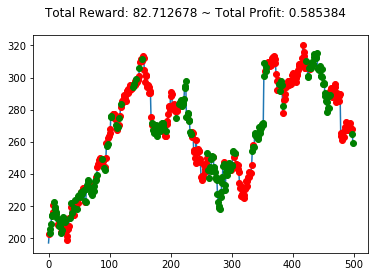

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
tf.keras.backend.set_floatx('float64')

# Our Experience Replay memory 
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
running_rewards_history = []

# Replay memory size
max_memory = 200 # You can experiment with different sizes.

running_reward = 0
episode_count = 0
timestep_count = 0
frame_count = 0

update_after_actions = 4

# How often to update the target network
target_update_every = 20
loss_function = keras.losses.MeanSquaredError()

epsilon = 1
adpative = True

state = env_1.reset()[0]
while True:
    timestep_count += 1
    
    # adpative epsilon decay
    if adpative:
        epsilon = np.exp(-1e-2 * timestep_count)
    
    # exploration
    rand = np.random.uniform(0, 1)
    if rand < epsilon:
        # Take random action
        action = np.random.choice(actsize)
    else:
        # Predict action Q-values
        # From environment state
        state_t = tf.convert_to_tensor(state)
        state_t = tf.expand_dims(state_t, 0)
        action_vals = model(state_t, training=False)
        # Choose the best action

        action = int(tf.keras.backend.argmax(action_vals))

    state_next, reward, done, info = env_1.step(action)
    state_next = state_next[0]

    
    # Save action/states and other information in replay buffer
    action_history.append(action)
    state_history.append(state)
    state_next_history.append(state_next)
    rewards_history.append(reward)
    done_history.append(done)
    running_rewards_history.append(info['total_reward'])
    
    running_reward = info['total_reward']

    state = state_next
    
    # Update every Xth frame to speed up (optional)
    # and if you have sufficient history
    if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:
        # Sample a set of batch_size memories from the history
        rand_samples = np.random.randint(0, len(action_history), batch_size)
        
        action_sample = np.array(action_history)[rand_samples]
        state_sample = np.array(state_history)[rand_samples]
        state_next_sample = np.array(state_next_history)[rand_samples]
        rewards_sample = np.array(rewards_history)[rand_samples]
        done_sample = np.array(done_history)[rand_samples]
        
        # Create for the sample states the targets (r+gamma * max Q(...)
        state_next_sample_t = tf.convert_to_tensor(state_next_sample)
        Q_next_state = np.max(model_target.predict(state_next_sample_t), axis=1)   
        Q_targets = rewards_sample + gamma * Q_next_state
        
        # What actions are relevant and need updating
        relevant_actions = tf.one_hot(action_sample, actsize)
        # we will use Gradient tape to do a custom gradient 
        # in the `with` environment we will record a set of operations
        # and then we will take gradients with respect to the trainable parameters
        # in the neural network
        with tf.GradientTape() as tape:
            # Train the model on your action selecting network
            q_values = model(state_sample) 
            # We consider only the relevant actions
            Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
            # Calculate loss between principal network and target network
            loss = loss_function(Q_targets, Q_of_actions)

            # Nudge the weights of the trainable variables towards 
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    if timestep_count % target_update_every == 0:
        # update the the target network with new weights
        model_target.set_weights(model.get_weights())
        # Log details
        template = "running reward: {:.2f} at episode {}, epsilon {}"
        print(template.format(running_reward, timestep_count, info, epsilon))
            
    # Don't let the memory grow beyond the limit
    if len(rewards_history) > max_memory:
        del action_history[:1]
        del state_history[:1]
        del state_next_history[:1]
        del rewards_history[:1]
        del done_history[:1]
    
    if done:
        print("info: ", info)
        break
    
env_1.render_all()